# Flatiron School Mod 3 Project

## Classifying Steam Games by Price

<h2 style="color:blue"> Overview: </h2>

### What we wanted to find out

We were insterested in seeing if computer games can be separated into 4 separate price categories based on the game information and the how the steam community views the game based on user reviews and recommendation. In this experiment, we tried to classify games as:

1. Less than $\$1.99$
2. Between $\$1.99 \;\&\; \$4.99$
3. Between $\$4.99 \;\&\; \$9.99$
4. More than $\$9.99$

These categories were determined by using the quartiles of the prices from our dataset.

<h2 style="color:blue"> The Experiment </h2>

### Step 1: Import necessary libraries

In [68]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from data_getter import *
from models_funcs import *
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn import svm
from scipy import interp
import warnings

warnings.filterwarnings('ignore')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Step 2: Gathering the data

<strong><i>Data gathering details</i></strong>
<p>To gather the data we scraped information of 76,000 games from steam.com. The data took quite some time to download because we had to include pauses to not get booted from the site. We also had to clean the data before we were able to download reviews since not all games had useful data. </p>


Please take a look at data_getter.py for the functions used to gather and clean the data.

<h4 style="color:green"> Main Data Gathering Functions</h4>
 
    # retrieve game info for all games
    def retrieve_steam_data(start, end):
        """
        takes a start index and end index as integers to slice the games list above
        return a list of dictionaries of game info
        """
        data_from_steam_ = []
        for num, game in enumerate(games[start: end]):
            if game["appid"] >= 10:
                data_from_steam_.append(get_game_info(game["appid"]))
            # save the data as a json after every thousand iterations
            if num % 1000 == 0 and num >0:
                t = np.random.choice([1,1.1,1.2,1.3,1.4,1.5])
                save_data(data_from_steam_, f"data_{start}_to_{end}.json")
                print(num, "Saved!")
                time.sleep(t)
            # pause making request to the site after every 100 iterations
            elif num % 100 == 0:
                t = np.random.choice([1,1.1,1.2,1.3,1.4,1.5])
                print(num, t)
                time.sleep(t)
        return data_from_steam_ 

    # retrieve user reviews for all games
    def retrieve_steam_reviews(start, end):
        """
        takes a list of game ids
        return a list of dictionaries of user reviews of all games in the id_list
        """
        data_from_steam_ = []
        for num, game in enumerate(games[start: end]):
            appid = game["appid"]
            data_from_steam_.append({appid: get_reviews(appid)})
            if num % 1000 == 0 and num >0:
                t = np.random.choice([1,1.1,1.2,1.3,1.4,1.5])
                save_data(data_from_steam_, f"upto_{num}_reviews.json")
                print(num, "Saved!")
                time.sleep(t)
            elif num % 100 == 0:
                t = np.random.choice([1,1.1,1.2,1.3,1.4,1.5])
                print(num, t)
                time.sleep(t)
        return data_from_steam_ 

In [2]:
# use the games list to retrieve the game info and review information
# examples of retrieving the data
print(retrieve_steam_reviews(0, 3))
print(retrieve_steam_data(0, 3))

0 1.4
[{216938: {'success': 2}}, {660010: {'success': 2}}, {660130: {'success': 2}}]
0 1.4
[{'216938': {'success': False}}, {'660010': {'success': False}}, {'660130': {'success': False}}]


In order to not overwhelm the website, get the data in intervals of 10,000.
    
    # first 10K
    K10_rev = retrieve_steam_reviews(0, 10000)
    K10_game_info = retrieve_steam_data(0, 10000)
    
    # second 10K
    K20_rev = retrieve_steam_reviews(10000, 20000)
    K20_game_info = retrieve_steam_data(10000, 20000)
    ...
    # final 10K
    K70_rev = retrieve_steam_reviews(60000, 70000)
    K70_game_info = retrieve_steam_data(60000, 70000)
    
    # last 6K
    K76_rev = retrieve_steam_reviews(70000, len(games))
    K76_game_info = retrieve_steam_data(70000, len(games))
    
After gathering each 10K data, combine them into one list. Then format and clean the data

    # all 76,000 games and reviews
    complete_rev_lst = K10_rev + K20_rev + K30_rev ... + K70_rev + 7K6Krev
    complete_games_lst = K10_game_info + K20_game_info + 3K0_game_info ... + K70_game_info + K76_game_info
    
    # save the data for easier access in the future
    save_data("76K_raw_reviews.json", complete_rev_lst)
    save_data("76K_raw_data.json", complete_games_lst)
    

### Step 3: Feature selection and engineering

<strong><i>Initial cleaning raw game data</i></strong>

<p> After gathering the data of all 76,000 games, we want to clean and format the data in a way that can be easily converted into a pandas dataframe. We use the functions below to reduce the number of games to about 22,700 by removing requests that failed. We also removed some features that we did not want to use to classify the price because they were information related to the steam website or they were closely related to another feature.</p>

<h4 style="color:green"> Initial Cleaning Functions</h4>

    # helper function
    def del_unwanted(dic, unwanted_lst):
    """
    takes a dictionary as dic
    takes a list of unwanted keys as unwanted_lst
    returns a copy of the dictionary dic with all the unwanted keys and values removed
    """
    dic_copy = copy.deepcopy(dic)
    for key in unwanted_lst:
        if key in dic_copy:
            del dic_copy[key]
    return dic_copy

    # initial cleaning function
    def clean_non_id_data(games_data_lst, start, end):
        """
        takes a dictionary of game data as games_data_lst
        takes an index of the where to begin the slice of the games_data_lst as start
        takes an index of the where to end the slice of the games_data_lst as end
        returns a list of game data that has the unnecessary keys and values removed
        """
        data_dic_lst = []
        data_f = copy.deepcopy(games_data_lst)
        for game in data_f[start:end]:
            if type(game) == dict:
                for key, val in game.items():
                    if "success" in val:
                            del val["success"]
                    if val != {}:
                        # use the helper func del_unwated to remove unnecessary keys and values
                        new_val = del_unwanted(val["data"], 
                        ["header_image", "website", "packages", "package_groups",
                         "screenshots", "movies", "support_info", "background",
                         "content_descriptors", "controller_support", "drm_notice",
                         "ext_user_account_notice", "detailed_description", 
                         "short_description", "legal_notice", "linux_requirements",
                         "mac_requirements", "fullgame", "publishers", "demos",
                         "pc_requirements", "release_date", 'alternate_appid', 
                          "release_date","about_the_game", "reviews", "developers"])
                    data_dic_lst.extend([new_val])
    return data_dic_lst

In [3]:
# importing a version previously saved of all 76,000 games
raw_game_data = open_save_data('76K_raw_data.json')

In [4]:
# example of what an item in the raw_game_data list looks like
print(len(raw_game_data))
raw_game_data[0]

75998


{'1013560': {'success': True,
  'data': {'type': 'game',
   'name': 'Starxium 20XX',
   'steam_appid': 1013560,
   'required_age': 0,
   'is_free': False,
   'controller_support': 'full',
   'detailed_description': '<i>&quot;I’m a 90s kid who didn’t get the chance to know the <strong>fantastic 80s</strong>. <strong>Starxium 20XX</strong> is a tribute to those <strong>fantasized years</strong> when everything seemed just fine, with lots of <strong>vibrant colors</strong>, <strong>bright neons</strong> and <strong>dreamy synths</strong>.&quot;</i><h2 class="bb_tag"><img src="https://steamcdn-a.akamaihd.net/steam/apps/1013560/extras/screen_01.png?t=1549799740" ></h2><br><br><strong>Starxium 20XX</strong> is a capture the point (your team needs to stay on a point and repel your opponent), where the point is a <strong>moving convoy</strong> that runs at <strong>200km/h</strong> in the middle of a big highway. It\'s <strong>not</strong> a racing game.<h2 class="bb_tag"><img src="https://stea

In [5]:
# some of the data to get rid off in the initial clean

# all None values
print(raw_game_data.count(None))
# any data that has a success: False
print(raw_game_data[57000])

50163
{'415113': {'success': False}}


In [6]:
# clean the data using the function
initial_clean = clean_non_id_data(raw_game_data, 0, len(raw_game_data))
initial_clean_df = pd.DataFrame(initial_clean)
initial_clean_df.head()

,achievements,categories,dlc,genres,is_free,metacritic,name,platforms,price_overview,recommendations,required_age,steam_appid,supported_languages,type
0,NaN,"[{'id': 2, 'description': 'Single-player'}, {'...",NaN,"[{'id': '1', 'description': 'Action'}, {'id': ...",False,NaN,Starxium 20XX,"{'windows': True, 'mac': False, 'linux': False}",NaN,NaN,0,1013560,English,game
1,"{'total': 15, 'highlighted': [{'name': 'Stabbe...","[{'id': 2, 'description': 'Single-player'}, {'...",NaN,"[{'id': '4', 'description': 'Casual'}, {'id': ...",False,NaN,Manna for our Malices,"{'windows': True, 'mac': True, 'linux': True}","{'currency': 'USD', 'initial': 499, 'final': 4...",NaN,0,1013580,English,game
2,"{'total': 18, 'highlighted': [{'name': 'Nimble...","[{'id': 2, 'description': 'Single-player'}, {'...",NaN,"[{'id': '1', 'description': 'Action'}, {'id': ...",False,NaN,Tiny Dangerous Dungeons,"{'windows': True, 'mac': True, 'linux': False}","{'currency': 'USD', 'initial': 499, 'final': 4...",NaN,0,1013650,English,game
3,"{'total': 10, 'highlighted': [{'name': 'Church...","[{'id': 2, 'description': 'Single-player'}, {'...",NaN,"[{'id': '1', 'description': 'Action'}, {'id': ...",False,NaN,Pursuer,"{'windows': True, 'mac': False, 'linux': False}","{'currency': 'USD', 'initial': 1399, 'final': ...",NaN,0,1013660,English<strong>*</strong><br><strong>*</strong...,game
4,{'total': 0},"[{'id': 1, 'description': 'Multi-player'}, {'i...",NaN,"[{'id': '1', 'description': 'Action'}, {'id': ...",False,NaN,Saint Paul Pre-Alpha,"{'windows': True, 'mac': False, 'linux': False}",NaN,NaN,0,1013680,"English<strong>*</strong>, Portuguese - Brazil...",game


In [7]:
initial_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22702 entries, 0 to 22701
Data columns (total 14 columns):
achievements           17343 non-null object
categories             21985 non-null object
dlc                    1695 non-null object
genres                 19402 non-null object
is_free                22702 non-null bool
metacritic             1176 non-null object
name                   22702 non-null object
platforms              22702 non-null object
price_overview         16752 non-null object
recommendations        2423 non-null object
required_age           22702 non-null object
steam_appid            22702 non-null int64
supported_languages    22110 non-null object
type                   22702 non-null object
dtypes: bool(1), int64(1), object(12)
memory usage: 2.3+ MB


<strong><i>Formatting of the data after an initial clean</i></strong>

<p> We had many categorical variables, many nan values, and certain columns were not formatted in a very usuable way. Do a second cleaning to create dummy variables for our categorical variables, such as genre and platform, change nan values to zero(we will deal with these in the future), and removed dictionaries and list from our columns and made them into more appropriate values.</p>

<h4 style="color:green"> Main Featuring Engineering and Selection Functions</h4>

    # cleans the data using all the feature cleaning functions
    def clean_data(raw_dic, keep=False):
        """
        takes a dictionary of game data which went through an initial cleaning process of removing failures and 
        None as raw_dic
        takes an optional boolean keep to determine if the raw_dic is changed or a new dictionary is returned
        returns a dictionary that has been completely cleaned by the the individual feature cleaning functions
        """
        clean_money(raw_dic, True, keep)
        clean_dev(raw_dic, keep)
        convert_to_1_0(raw_dic, keep)
        dlc_reformatting(raw_dic, keep)
        get_clean_dummies(raw_dic, "categories", cats, keep)
        get_clean_dummies(raw_dic, "genres", genres, keep)
        get_total_from_dic(raw_dic, "recommendations", keep)
        get_total_from_dic(raw_dic, "achievements", keep)
        get_platform_dummies(raw_dic, keep)
        get_metas_from_dic(raw_dic, keep)
        clean_language(raw_dic, keep=keep)
        return pd.DataFrame(raw_dic)
            
    # cleans and structures the review in a certain format    
    def clean_review(lst_reviews):
        """
        takes in a list of unformatted reviews as lst_reviews
        returns a list of properly formatted reviews
        """
        check = ['review_score','total_positive', 'total_negative', 'total_reviews']
        data_storage = []
        for rev in lst_reviews:
            app_id = list(rev.keys())[0]
            review_dict = {}
            review_dict["steam_appid"] = int(app_id)
            review_dict["reviews"] = ""
            for key in check:
                if "query_summary" in rev[app_id]:
                    if key in rev[app_id]["query_summary"]:
                        review_dict[key] = rev[app_id]["query_summary"][key]
            if "reviews" in rev[app_id]:
                for text in rev[app_id]["reviews"]:
                    review_dict["reviews"] += " " + text["review"]
            data_storage.append(review_dict)
        return data_storage
    


In [8]:
# put the list of the clean data in the clean_data function and set the second parameter to False
cleaned_game_df = clean_data(initial_clean, False)
cleaned_game_df.head()

,Action,Adventure,Casual,Co-op,Cross-Platform Multiplayer,Early Access,Free to Play,Indie,Local Co-op,Local Multi-Player,...,mac,metacritic,name,num_supported_languages,price_overview,recommendations,required_age,steam_appid,type,windows
0,1,0,0,1,0,0,0,1,1,1,...,0,0,Starxium 20XX,1,0.00,0,0,1013560,game,1
1,0,0,1,0,0,0,0,1,0,0,...,1,0,Manna for our Malices,1,4.99,0,0,1013580,game,1
2,1,1,0,0,0,0,0,1,0,0,...,1,0,Tiny Dangerous Dungeons,1,4.99,0,0,1013650,game,1
3,1,1,0,0,0,0,0,1,0,0,...,0,0,Pursuer,1,13.99,0,0,1013660,game,1
4,1,1,0,0,0,0,1,1,0,0,...,0,0,Saint Paul Pre-Alpha,2,0.00,0,0,1013680,game,1


In [9]:
# remove all the data whose type is not game
cleaned_game_df = cleaned_game_df[(cleaned_game_df.type == "game")]

<strong><i>Cleaning review data</i></strong>

In [10]:
# importing a version previously saved of all 76,000 review
all_reviews = open_save_data("76K_raw_review.json")

# preview of how the data is set-up
all_reviews[0]

{'359550': {'success': 1,
  'query_summary': {'num_reviews': 20,
   'review_score': 8,
   'review_score_desc': 'Very Positive',
   'total_positive': 88321,
   'total_negative': 20870,
   'total_reviews': 109191},
  'reviews': [{'recommendationid': '49790434',
    'author': {'steamid': '76561198357250423',
     'num_games_owned': 6,
     'num_reviews': 1,
     'playtime_forever': 18862,
     'playtime_last_two_weeks': 2048,
     'last_played': 1553702125},
    'language': 'english',
    'review': 'the most shit  game you will ever play , for the first time you will like it cuz it feels unique with gun fight and the fighting system , but the more you play the more you see how shit this game is full of bugs glitches really really bad tech support  , I talked to ubishit about my season pass that cost 30 fuckin euros , that it just gone from my account for no reason and I made a ticket and it has been 5 fuckin days with the only reply I got was the auto e-mail you get to  tell you that you 

In [11]:
# clean the data using the function
clean_reviews = clean_review(all_reviews)
clean_reviews_df = pd.DataFrame(clean_reviews)
clean_reviews_df.head()

,review_score,reviews,steam_appid,total_negative,total_positive,total_reviews
0,8.0,"the most shit game you will ever play , for ...",359550,20870.0,88321.0,109191.0
1,8.0,"the most shit game you will ever play , for ...",359550,20870.0,88321.0,109191.0
2,8.0,"the most shit game you will ever play , for ...",359550,20870.0,88321.0,109191.0
3,8.0,"the most shit game you will ever play , for ...",359550,20870.0,88321.0,109191.0
4,0.0,"[h1]Located in ""?:\steam games\steamapps\comm...",475010,0.0,1.0,1.0


<strong><i>Sort and merge reviews and game info</i></strong>

<u><i>Remove Duplicates</i></u><br><br>
There are some duplicates that need to be removed before merging with the games dataframe. We will sort both game dataframe and the review dataframe in order to confirm that the merge is successful. After this process, we end up with about 11,000 rows of data.

In [12]:
# sort and drop_duplicates
cleaned_game_df.sort_values("steam_appid", inplace=True)
clean_reviews_df.sort_values("steam_appid", inplace=True)
cleaned_game_df.drop_duplicates("steam_appid", inplace=True)
clean_reviews_df.drop_duplicates("steam_appid", inplace=True)

In [13]:
# view head to see if they match
cleaned_game_df.head()

,Action,Adventure,Casual,Co-op,Cross-Platform Multiplayer,Early Access,Free to Play,Indie,Local Co-op,Local Multi-Player,...,mac,metacritic,name,num_supported_languages,price_overview,recommendations,required_age,steam_appid,type,windows
20140,1,0,0,0,0,0,0,0,0,1,...,1,88,Counter-Strike,8,9.99,65391,0,10,game,1
20143,1,0,0,0,0,0,0,0,0,1,...,1,0,Team Fortress Classic,9,4.99,2786,0,20,game,1
20144,1,0,0,0,0,0,0,0,0,0,...,1,79,Day of Defeat,5,4.99,1979,0,30,game,1
20148,1,0,0,0,0,0,0,0,0,1,...,1,0,Deathmatch Classic,9,4.99,922,0,40,game,1
20145,1,0,0,0,0,0,0,0,0,0,...,1,0,Half-Life: Opposing Force,4,4.99,4304,0,50,game,1


In [14]:
# reviews head
clean_reviews_df.head()

,review_score,reviews,steam_appid,total_negative,total_positive,total_reviews
17905,9.0,Perfect childhood game! Acest joc pot sa spun...,10,964.0,32367.0,33331.0
17906,8.0,i have no idea what im doing. I've always lik...,20,405.0,2172.0,2577.0
17907,8.0,Too many hicks in this game! Zivoragnom!!! Ve...,30,191.0,1660.0,1851.0
17908,8.0,Shame no one plays it its kinda like roblox h...,40,134.0,708.0,842.0
17909,8.0,"Loved half-life 1, one of my favorite games. ...",50,163.0,2897.0,3060.0


In [15]:
cleaned_game_df.reset_index(inplace=True)
clean_reviews_df.reset_index(inplace=True)

In [16]:
cleaned_game_df.drop("index", axis=1, inplace=True)
clean_reviews_df.drop("index", axis=1, inplace=True)

Now merge the two dataframes

In [17]:
final_df = cleaned_game_df.merge(clean_reviews_df, on="steam_appid")
final_df.tail()

,Action,Adventure,Casual,Co-op,Cross-Platform Multiplayer,Early Access,Free to Play,Indie,Local Co-op,Local Multi-Player,...,recommendations,required_age,steam_appid,type,windows,review_score,reviews,total_negative,total_positive,total_reviews
11122,0,0,1,0,0,0,0,1,0,0,...,0,0,1054610,game,1,0.0,,0.0,0.0,0.0
11123,1,1,1,0,0,0,0,1,0,0,...,0,0,1054950,game,1,0.0,,0.0,0.0,0.0
11124,0,0,0,0,0,0,0,1,0,0,...,0,0,1054980,game,1,0.0,,0.0,0.0,0.0
11125,0,1,1,0,0,0,0,1,0,0,...,0,0,1055150,game,1,0.0,,0.0,0.0,0.0
11126,0,1,0,0,0,0,0,0,0,0,...,0,0,1055950,game,1,0.0,,0.0,0.0,0.0


In [18]:
final_df.shape

(11127, 40)

In [19]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11127 entries, 0 to 11126
Data columns (total 40 columns):
Action                        11127 non-null int64
Adventure                     11127 non-null int64
Casual                        11127 non-null int64
Co-op                         11127 non-null int64
Cross-Platform Multiplayer    11127 non-null int64
Early Access                  11127 non-null int64
Free to Play                  11127 non-null int64
Indie                         11127 non-null int64
Local Co-op                   11127 non-null int64
Local Multi-Player            11127 non-null int64
Massively Multiplayer         11127 non-null int64
Multi-player                  11127 non-null int64
Online Co-op                  11127 non-null int64
Online Multi-Player           11127 non-null int64
RPG                           11127 non-null int64
Racing                        11127 non-null int64
Shared/Split Screen           11127 non-null int64
Simulation              

In [20]:
# drop columns that are not numerical or are not features we will use like app id
final_df.drop(["reviews", "steam_appid", "name", "type"], axis=1, inplace=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11127 entries, 0 to 11126
Data columns (total 36 columns):
Action                        11127 non-null int64
Adventure                     11127 non-null int64
Casual                        11127 non-null int64
Co-op                         11127 non-null int64
Cross-Platform Multiplayer    11127 non-null int64
Early Access                  11127 non-null int64
Free to Play                  11127 non-null int64
Indie                         11127 non-null int64
Local Co-op                   11127 non-null int64
Local Multi-Player            11127 non-null int64
Massively Multiplayer         11127 non-null int64
Multi-player                  11127 non-null int64
Online Co-op                  11127 non-null int64
Online Multi-Player           11127 non-null int64
RPG                           11127 non-null int64
Racing                        11127 non-null int64
Shared/Split Screen           11127 non-null int64
Simulation              

<strong><i>Final clean before exploring the data</i></strong>

For this project, our goal is to classify into 4 different price range. To do this we must make sure that we get the correct price ranges for each row. We will drop all rows whose is_free column is set to 0, however, their price_overview is 0.

In [21]:
final_df = final_df[((final_df.is_free == 1) & (final_df.price_overview == 0)) | (final_df.price_overview > 0)]
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9955 entries, 0 to 11102
Data columns (total 36 columns):
Action                        9955 non-null int64
Adventure                     9955 non-null int64
Casual                        9955 non-null int64
Co-op                         9955 non-null int64
Cross-Platform Multiplayer    9955 non-null int64
Early Access                  9955 non-null int64
Free to Play                  9955 non-null int64
Indie                         9955 non-null int64
Local Co-op                   9955 non-null int64
Local Multi-Player            9955 non-null int64
Massively Multiplayer         9955 non-null int64
Multi-player                  9955 non-null int64
Online Co-op                  9955 non-null int64
Online Multi-Player           9955 non-null int64
RPG                           9955 non-null int64
Racing                        9955 non-null int64
Shared/Split Screen           9955 non-null int64
Simulation                    9955 non-nul

In [22]:
final_df.head()

,Action,Adventure,Casual,Co-op,Cross-Platform Multiplayer,Early Access,Free to Play,Indie,Local Co-op,Local Multi-Player,...,metacritic,num_supported_languages,price_overview,recommendations,required_age,windows,review_score,total_negative,total_positive,total_reviews
0,1,0,0,0,0,0,0,0,0,1,...,88,8,9.99,65391,0,1,9.0,964.0,32367.0,33331.0
1,1,0,0,0,0,0,0,0,0,1,...,0,9,4.99,2786,0,1,8.0,405.0,2172.0,2577.0
2,1,0,0,0,0,0,0,0,0,0,...,79,5,4.99,1979,0,1,8.0,191.0,1660.0,1851.0
3,1,0,0,0,0,0,0,0,0,1,...,0,9,4.99,922,0,1,8.0,134.0,708.0,842.0
4,1,0,0,0,0,0,0,0,0,0,...,0,4,4.99,4304,0,1,8.0,163.0,2897.0,3060.0


We now have our final dataset of about 9900 rows of data and 36 columns, which we will split into our features and target variables. Next, let's explore the data.

### Step 3: Explore Data

<strong><i>Initial exploration of the data</i></strong>

<u><i>Distribution of the target variable</i></u>

The target will be the price_overview. After some initial analysis of the target, we will divide our dataset into features and target in the following way.

features= final_df.drop("price_overview", axis=1)
target = final_df.price_overview

In [26]:
target = pd.DataFrame(final_df.price_overview)
target.describe()

,price_overview
count,9955.000000
mean,7.951766
std,12.714428
min,0.000000
25%,1.990000
50%,4.990000
75%,9.990000
max,595.990000


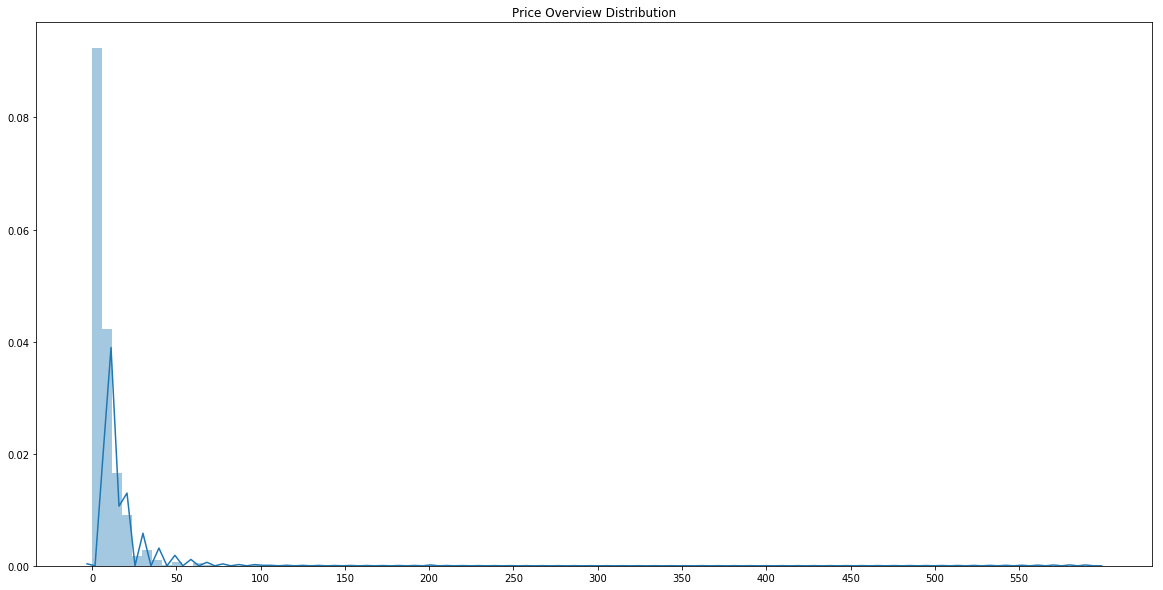

In [27]:
plt.figure(figsize=[20,10])
sns.distplot(target, bins=100);
plt.title("Price Overview Distribution");
plt.xticks(range(0,600, 50));

The distribution of the price is not normally distributed and has a negative skew. Most of the data is under 50 dollars. Let's look at the price_overviews that are over 10 dollars, since 75% of the data in our set is less than 10 dollars.

In [28]:
target[target["price_overview"] > 10].describe()

,price_overview
count,2011.000000
mean,22.176698
std,22.382671
min,10.790000
25%,14.990000
50%,16.990000
75%,19.990000
max,595.990000


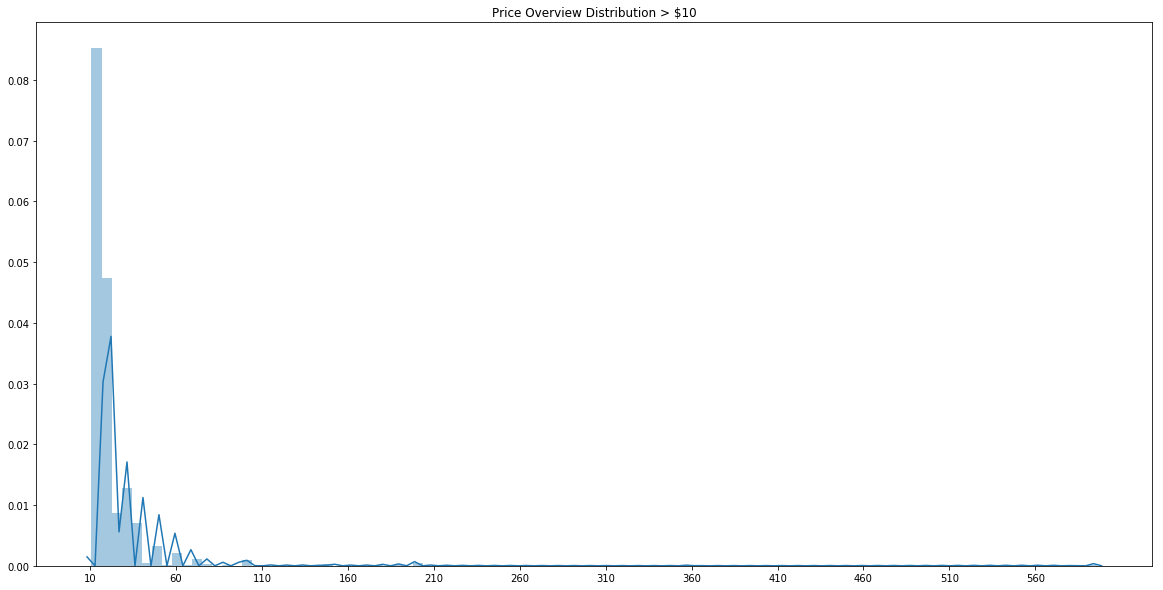

In [29]:
plt.figure(figsize=[20,10])
sns.distplot(target[target["price_overview"] > 10], bins=100);
plt.title("Price Overview Distribution > $10");
plt.xticks(range(10,600, 50));

It seems like there are many games between 10 dollars and about 20 dollars. Let's continue looking at games greater than 20 dollars.

In [30]:
target[target["price_overview"] > 20].describe()

,price_overview
count,454.000000
mean,43.072048
std,40.344288
min,20.090000
25%,29.990000
50%,29.990000
75%,39.990000
max,595.990000


75% of the distribution lies within a 20 dollars increase. Let's see what happens for 50 dollars.

In [31]:
target[target["price_overview"] > 50].describe()

,price_overview
count,69.000000
mean,100.926812
std,80.560066
min,54.990000
25%,59.990000
50%,69.990000
75%,99.990000
max,595.990000


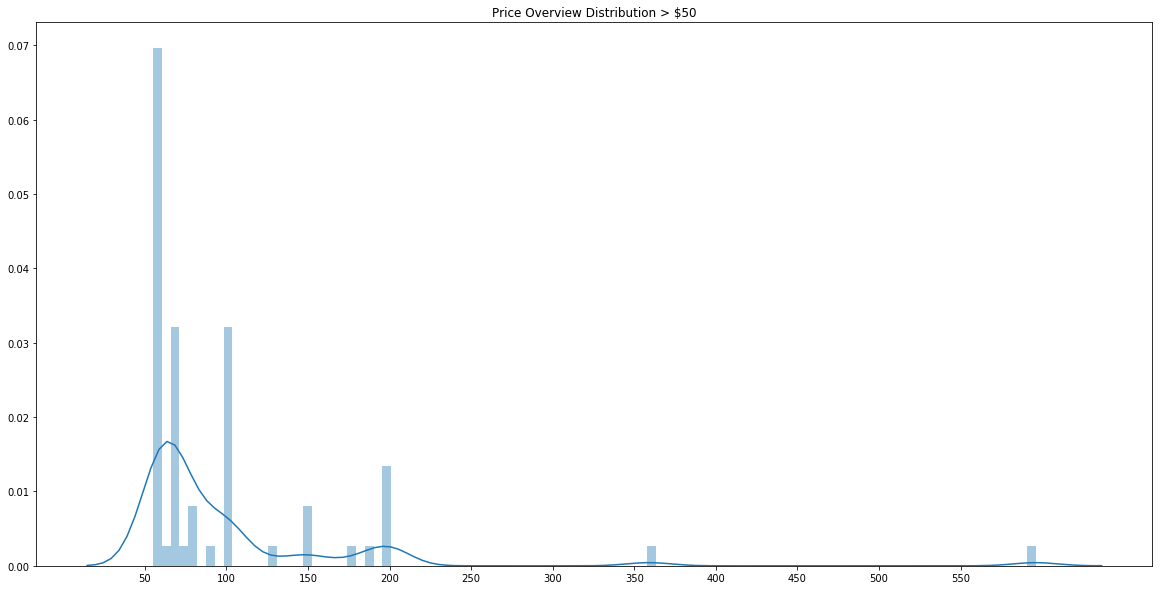

In [32]:
plt.figure(figsize=[20,10])
sns.distplot(target[target["price_overview"] > 50], bins=100);
plt.title("Price Overview Distribution > $50");
plt.xticks(range(50,600, 50));

We finally see a some gaps in the distribution. It is clear that most games are under 70 dollars so we will drop all games over 200 dollars.

In [33]:
target[target["price_overview"] > 70].describe()

,price_overview
count,30.000000
mean,150.158667
std,103.689129
min,74.990000
25%,99.990000
50%,99.990000
75%,186.500000
max,595.990000


There are 30 rows of data being dropped which is approximately 3% of our data.

In [36]:
target = target[target["price_overview"] <= 70]
target.describe()

,price_overview
count,9925.000000
mean,7.521921
std,8.331244
min,0.000000
25%,1.990000
50%,4.990000
75%,9.990000
max,69.990000


Our standard deviation dropped to 8. Since we are interested in categorizing min-25%, 25%-50%,  50%-75%, and  50%-max, we will keep the other outliers. Now we can divide final_df into features and target, eliminating price_overview > 70.

In [35]:
final_df1 = final_df[final_df.price_overview <= 70]
features = final_df1.drop("price_overview", axis=1)
target = final_df1[["price_overview"]]

<u><i>Heatmap</i></u><br>
Take a look at the heatmap to check for multicollinearity.

    correlations = final_df1.corr()

    plt.figure(figsize=(15,8))
    mask = np.zeros_like(correlations, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    cmap = sns.diverging_palette(10, 200, as_cmap=True)
    plt.title("Features Heatmap")
    sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.5, center=0, 
            square=True, linewidths=.5)

<img src="corr.png" alt="correlation heat map"/>

The data does not have much multicollinearity, which means that our features have low correlation with one another.

<strong><i>Relationship between target and features</i></strong>

We will plot our target against our non-binary features
               ['num_supported_languages','metacritic','review_score','total_negative','total_positive','total_reviews','dlc','achievements','required_age','recommendations']
               
<u><i>Scatterplots</i></u><br>

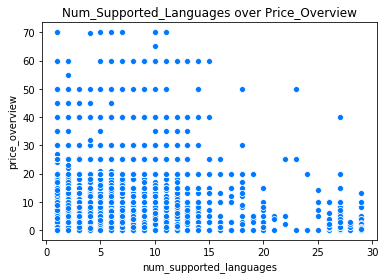

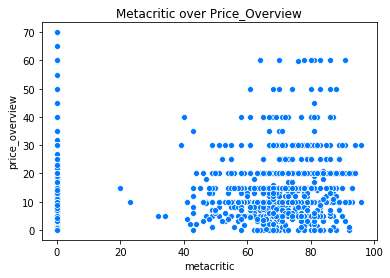

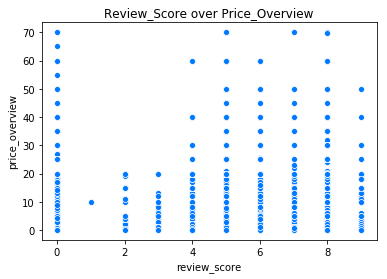

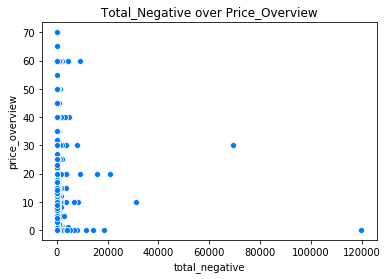

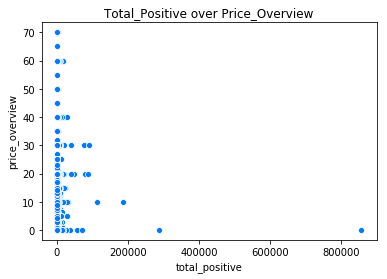

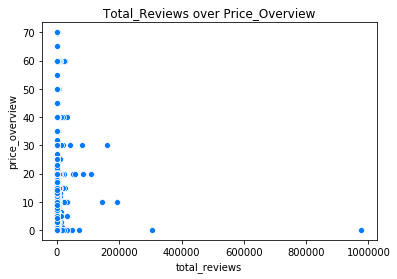

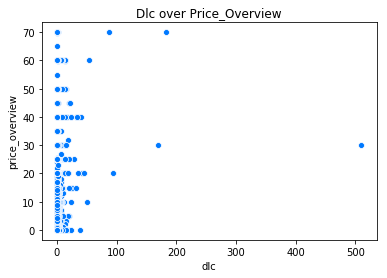

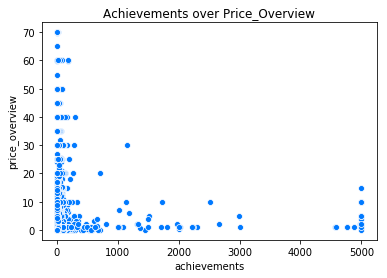

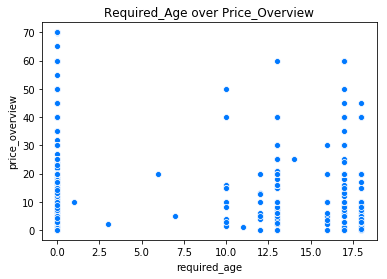

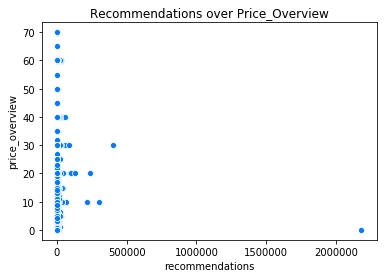

In [37]:
non_binary_features = ['num_supported_languages','metacritic','review_score','total_negative','total_positive',
                       'total_reviews','dlc','achievements','required_age','recommendations']

for feat in non_binary_features:
    sns.scatterplot(features[feat], target.price_overview, color="#0079ff")
    plt.title(feat.title() + " over Price_Overview")
    plt.show()

### Step 4: Second Round of Feature Selection and Engineering

<strong><i>Feature Selection after first exploration</i></strong>

After an initial exploration, we noticed that we have non-binary variables that act more like categorical variables than continuous ones. In order to not increase dimensionality too much we will drop number_of_supported_languages and required_age. However, we will get the dummy variables for review score.

In [38]:
features = features.drop(["num_supported_languages", "required_age"], axis=1)
features.columns

Index(['Action', 'Adventure', 'Casual', 'Co-op', 'Cross-Platform Multiplayer',
       'Early Access', 'Free to Play', 'Indie', 'Local Co-op',
       'Local Multi-Player', 'Massively Multiplayer', 'Multi-player',
       'Online Co-op', 'Online Multi-Player', 'RPG', 'Racing',
       'Shared/Split Screen', 'Simulation', 'Single-player', 'Sports',
       'Strategy', 'achievements', 'dlc', 'is_free', 'linux', 'mac',
       'metacritic', 'recommendations', 'windows', 'review_score',
       'total_negative', 'total_positive', 'total_reviews'],
      dtype='object')

In [39]:
rs_dummies = pd.get_dummies(features.review_score, prefix="RS", drop_first=True)

In [40]:
features = features.merge(rs_dummies, on=features.index)
features.drop(["key_0", "review_score"], axis=1, inplace=True )

In [41]:
features.shape

(9925, 41)

We will do PCA on the other non-binary variable in the features set. But before that, we must scale those vairables using a StandardScalar.

<u><i>Standard Scaler</i></u><br>

In [42]:
feats_to_scale = features[['metacritic','total_negative','total_positive',
                  'total_reviews','dlc','achievements','recommendations']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feats_to_scale)

For our PCA, we want components that account for 95% of our original data.

In [43]:
pca = PCA(.95)
principal_comps = pca.fit_transform(scaled_features)

<u><i>PCA Scree Plot</i></u><br>

Text(0, 0.5, 'Variance Ration Explanation')

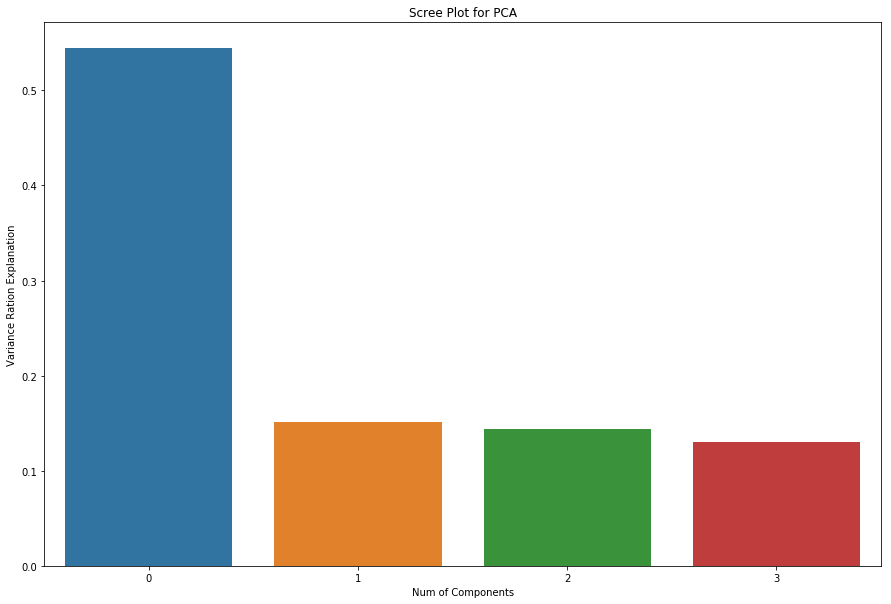

In [44]:
index = np.arange(len(pca.explained_variance_ratio_ ))
plt.figure(figsize=(15,10))
sns.barplot(index, pca.explained_variance_ratio_ )
plt.title("Scree Plot for PCA")
plt.xlabel("Num of Components")
plt.ylabel("Variance Ration Explanation")

In [45]:
principal_df = pd.DataFrame(data=principal_comps, columns=[f"PC_{i}" for i in range(len(pca.explained_variance_ratio_))])
principal_df.head()


,PC_0,PC_1,PC_2,PC_3
0,5.156356,1.683185,-1.732702,-2.392509
1,0.298791,-0.307877,0.046653,0.209884
2,0.446256,1.831166,-1.691546,-2.272536
3,0.014852,-0.290256,0.038886,0.200545
4,0.313859,-0.314745,0.048653,0.210359


In [46]:
features = features.drop(feats_to_scale.columns, axis=1)

In [47]:
features = features.merge(principal_df, on=features.index)
features.drop("key_0", axis=1, inplace=True)
features.shape

(9925, 38)

We were able to reduce our dimensionality from 41 features to 38. We will run our model on these features.

In [48]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9925 entries, 0 to 9924
Data columns (total 38 columns):
Action                        9925 non-null int64
Adventure                     9925 non-null int64
Casual                        9925 non-null int64
Co-op                         9925 non-null int64
Cross-Platform Multiplayer    9925 non-null int64
Early Access                  9925 non-null int64
Free to Play                  9925 non-null int64
Indie                         9925 non-null int64
Local Co-op                   9925 non-null int64
Local Multi-Player            9925 non-null int64
Massively Multiplayer         9925 non-null int64
Multi-player                  9925 non-null int64
Online Co-op                  9925 non-null int64
Online Multi-Player           9925 non-null int64
RPG                           9925 non-null int64
Racing                        9925 non-null int64
Shared/Split Screen           9925 non-null int64
Simulation                    9925 non-null

<strong><i>Converting Target to Classes</i></strong>

Lastly, we change our target so that they are classes of prince ranges.

    Class 1 = price_overview <= target.quartile(.25)
    Class 2 = target.quartile(.25) > price_overview <= target.quartile(.50)
    Class 3 = target.quartile(.50) > price_overview <= target.quartile(.75)
    Class 4 = price_overview > target.quartile(.75)

In [49]:
target.describe()

,price_overview
count,9925.000000
mean,7.521921
std,8.331244
min,0.000000
25%,1.990000
50%,4.990000
75%,9.990000
max,69.990000


At a quick glance, it seems that our classes are the following:

    Class 1 = games <= 1.99
    Class 2 = games between 4.99 and 1.99
    Class 3 = games between 9.99 and 4.99
    Class 4 = games > 9.99 

In [50]:
target_classes = target.copy()
target_classes[target_classes.price_overview <= target_classes.price_overview.quantile(.25)] = 1
target_classes[(target_classes.price_overview > target_classes.price_overview.quantile(.25)) & (target_classes.price_overview <= target_classes.price_overview.quantile(.50))] =2
target_classes[(target_classes.price_overview > target_classes.price_overview.quantile(.50)) & (target_classes.price_overview <= target_classes.price_overview.quantile(.75))] =3
target_classes[(target_classes.price_overview > target_classes.price_overview.quantile(.75))] = 4
target_classes.head()



,price_overview
0,3.0
1,2.0
2,2.0
3,2.0
4,2.0


### Step 5: Building the Models

<strong><i>Baseline Model</i></strong>

Our first model is a decision tree with all the default parameters.

<h4 style="color:green"> Main Functions for Model Analysis</h4>

    
    # prints out the metrics for the model
    def run_reports(model, X_train, y_true, y_pred, y_type="train", plot=False):
        """
        takes a model as model
        takes the training features as X_train
        takes the testing features as X_test
        takes the true target values as y_true
        takes the prediction of targets as y_pred
        takes an optional target type(train or test) as y_type
        takes optional flag of plot
        """
        
        print("Accuracy Report:")
        print(f"Our {y_type} accuracy is :{0}".format(acc))
        acc = accuracy_score(y_train, y_pred) * 100
        print("Classification Report:")
        print(pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)))
        if plot:
            plot_feature_importances(model, y_type + "'s Feature of Importance", X_train)


<h4 style="color:green"> Decision Tree Modeling Function</h4>
    
    # creates a decision tree model and does the prediction for test and train 
    def decision_tree(Xtrain, Xtest, ytrain, ytest, criterion="gini", max_depth=None):
        """
        takes the training features as Xtrain
        takes the testing features as Xtest
        takes the training targets as ytrain
        takes the testing targets as ytest
        takes optional parameters for the decision tree
        returns the model, prediction on the training, and prediction on the testing
        """
        clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
        clf.fit(Xtrain, ytrain)
        y_pred_train = clf.predict(Xtrain)
        y_pred_test = clf.predict(Xtest)
        return clf, y_pred_train, y_pred_test
        
<u><i>Train Test Split</i></u><br>

We will choose a random state in order to replicate the experiment.

In [51]:
# an 80/20 split of our data into training and testing sets
feat_train, feat_test, target_train, target_test = train_test_split(features, target_classes, 
                                                                    test_size=.2, random_state=56)

# baseline model with default paramenters

clf, train_pred, test_pred = decision_tree(feat_train, feat_test, target_train, 
                                           target_test, criterion="gini", max_depth=None)

# analysis of the model on the train
run_reports(clf, feat_train,  target_train, train_pred)

print("\n")
# analysis of the model on the test
run_reports(clf, feat_train,  target_test, test_pred, y_type="test")

Accuracy Report:
Our train accuracy is: 96.64987405541562
Classification Report:
                   1.0          2.0          3.0          4.0    micro avg  \
f1-score      0.968118     0.958169     0.968678     0.972168     0.966499   
precision     0.953612     0.956287     0.981424     0.981699     0.966499   
recall        0.983072     0.960059     0.956259     0.962821     0.966499   
support    2363.000000  2028.000000  1989.000000  1560.000000  7940.000000   

             macro avg  weighted avg  
f1-score      0.966784      0.966513  
precision     0.968256      0.966781  
recall        0.965553      0.966499  
support    7940.000000   7940.000000  


Accuracy Report:
Our test accuracy is: 42.51889168765743
Classification Report:
                  1.0         2.0         3.0         4.0    micro avg  \
f1-score     0.567063    0.344196    0.323618    0.441718     0.425189   
precision    0.570940    0.337325    0.318182    0.458015     0.425189   
recall       0.563238    0.35

Accuracy Report:
Our test accuracy is: 29.269521410579348
Classification Report:
                    0           1           2           3    micro avg  \
f1-score     0.569758    0.315251    0.352709    0.434884     0.425290   
precision    0.564570    0.310484    0.340304    0.426941     0.417151   
recall       0.575042    0.320166    0.366053    0.443128     0.433753   
support    593.000000  481.000000  489.000000  422.000000  1985.000000   

             macro avg  weighted avg  samples avg  
f1-score      0.418150      0.425943     0.383560  
precision     0.410575      0.418494     0.360076  
recall        0.426097      0.433753     0.433753  
support    1985.000000   1985.000000  1985.000000  


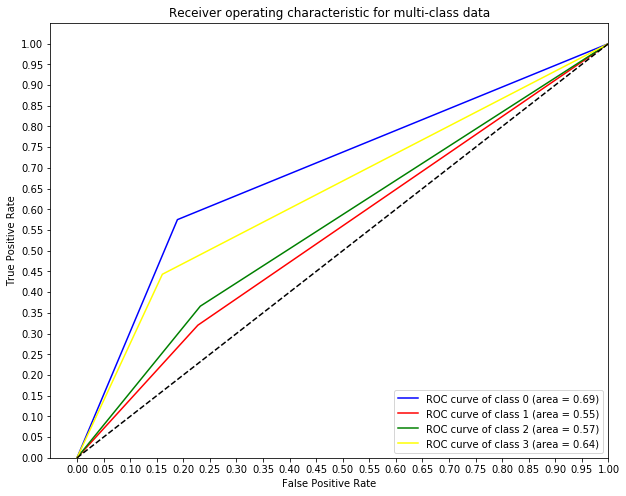

In [52]:
y = label_binarize(target_classes, classes=[1, 2, 3, 4])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=.2, random_state=56)

classifier = OneVsRestClassifier(DecisionTreeClassifier())
y_score = classifier.fit(X_train, y_train).predict(X_test)


run_reports(classifier, feat_train, y_test, y_score, y_type="test")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'yellow'])
plt.figure(figsize=(10,8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

<strong><i>Analysis of Baseline Model</i></strong>

Our baseline model overfit the training set with an accuracy of %96 for the training, but an accuracy of %42 for the test set. From the classification report, it seems that the model was getting better results for our first class, however, still significantly bad. 

Before tuning any parameters, let's see if a different model will give us a better baseline result.

<strong><i>Baseline Random Forest </i></strong>



Accuracy Report:
Our train accuracy is: 95.16372795969772
Classification Report:
                   1.0          2.0          3.0          4.0    micro avg  \
f1-score      0.957125     0.941205     0.952768     0.955513     0.951637   
precision     0.950731     0.935248     0.962545     0.961089     0.951637   
recall        0.963606     0.947239     0.943188     0.950000     0.951637   
support    2363.000000  2028.000000  1989.000000  1560.000000  7940.000000   

             macro avg  weighted avg  
f1-score      0.951653      0.951651  
precision     0.952403      0.951771  
recall        0.951008      0.951637  
support    7940.000000   7940.000000  


Accuracy Report:
Our test accuracy is: 46.549118387909324
Classification Report:
                  1.0         2.0         3.0         4.0    micro avg  \
f1-score     0.597701    0.392927    0.366492    0.474968     0.465491   
precision    0.582400    0.372439    0.375536    0.518207     0.465491   
recall       0.613828    0.4

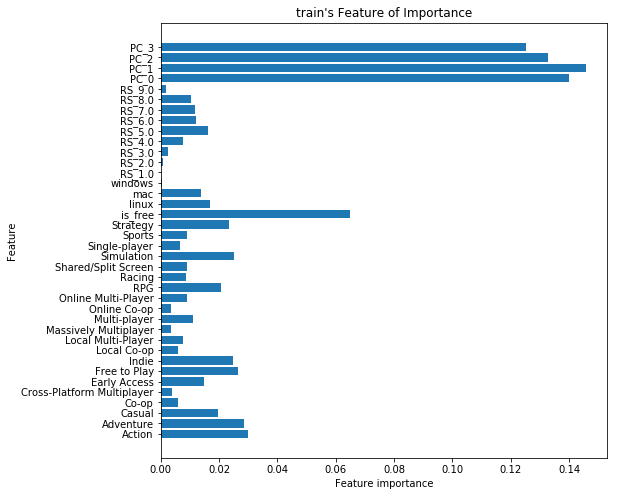

In [56]:
r_clf = RandomForestClassifier()
r_clf.fit(feat_train, target_train)
pred_train = r_clf.predict(feat_train)
pred_test = r_clf.predict(feat_test)

run_reports(r_clf, feat_train,  target_train, pred_train, y_type="train", plot=True)
print("\n")
run_reports(r_clf, feat_train,  target_test, pred_test, y_type="test")

The Random Forest performed better, but still not predicting over 50% on the test set and the model has overfit on the training set. Let's test out XGboost.

<strong><i>Baseline XGBoost </i></strong>

Accuracy Report:
Our train accuracy is: 52.73299748110831
Classification Report:
                   1.0          2.0          3.0          4.0   micro avg  \
f1-score      0.658488     0.444396     0.438841     0.564120     0.52733   
precision     0.682561     0.398980     0.470385     0.585517     0.52733   
recall        0.636056     0.501479     0.411262     0.544231     0.52733   
support    2363.000000  2028.000000  1989.000000  1560.000000  7940.00000   

             macro avg  weighted avg  
f1-score      0.526461      0.530242  
precision     0.534361      0.537913  
recall        0.523257      0.527330  
support    7940.000000   7940.000000  


Accuracy Report:
Our test accuracy is: 47.607052896725435
Classification Report:
                  1.0         2.0         3.0         4.0    micro avg  \
f1-score     0.641410    0.394213    0.357688    0.490148     0.476071   
precision    0.671587    0.348800    0.383178    0.510256     0.476071   
recall       0.613828    0.453222

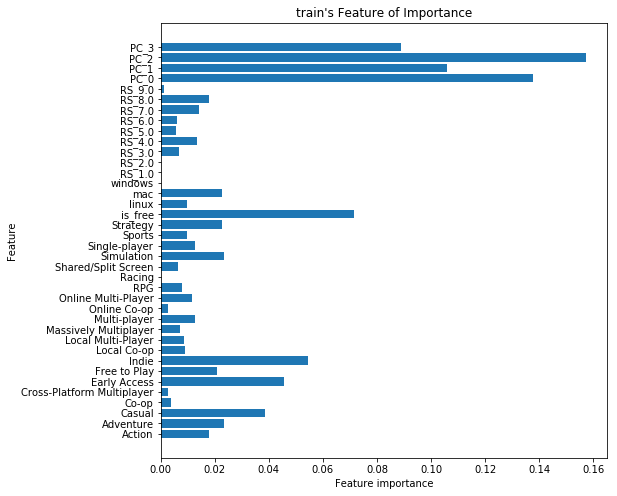

In [58]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

x_clf = xgb.XGBClassifier()
x_clf.fit(feat_train, target_train)
pred_train = x_clf.predict(feat_train)
pred_test = x_clf.predict(feat_test)

run_reports(x_clf, feat_train,  target_train, pred_train, y_type="train", plot=True)
print("\n")
run_reports(x_clf, feat_train,  target_test, pred_test, y_type="test")

In [70]:
k_clf = KNeighborsClassifier()
k_clf.fit(feat_train, target_train)
pred_train = k_clf.predict(feat_train)
pred_test = k_clf.predict(feat_test)

run_reports(k_clf, feat_train,  target_train, pred_train, y_type="train")
print("\n")
run_reports(k_clf, feat_train,  target_test, pred_test, y_type="test")

Train Report:
Our train accuracy is: 60.55415617128463
Train Classification Report:
                   1.0          2.0          3.0          4.0    micro avg  \
f1-score      0.717537     0.550255     0.535753     0.571753     0.605542   
precision     0.654571     0.518777     0.580740     0.698427     0.605542   
recall        0.793906     0.585799     0.497235     0.483974     0.605542   
support    2363.000000  2028.000000  1989.000000  1560.000000  7940.000000   

             macro avg  weighted avg  
f1-score      0.593824      0.600630  
precision     0.613129      0.610009  
recall        0.590229      0.605542  
support    7940.000000   7940.000000  


Test Report:
Our test accuracy is: 41.612090680100756
Test Classification Report:
                  1.0         2.0         3.0         4.0    micro avg  \
f1-score     0.592126    0.355394    0.281909    0.364943     0.416121   
precision    0.555391    0.315113    0.308252    0.463504     0.416121   
recall       0.634064   

In [64]:
s_clf = svm.SVC()
s_clf.fit(feat_train, target_train)
pred_train = s_clf.predict(feat_train)
pred_test = s_clf.predict(feat_test)

run_reports(s_clf, feat_train,  target_train, pred_train, y_type="train")
print("\n")
run_reports(s_clf, feat_train,  target_test, pred_test, y_type="test")

Accuracy Report:
Our train accuracy is: 47.670025188916874
Classification Report:
                   1.0          2.0          3.0          4.0  micro avg  \
f1-score      0.641438     0.394446     0.367109     0.481415     0.4767   
precision     0.640896     0.352189     0.388546     0.550784     0.4767   
recall        0.641981     0.448225     0.347914     0.427564     0.4767   
support    2363.000000  2028.000000  1989.000000  1560.000000  7940.0000   

             macro avg  weighted avg  
f1-score      0.471102      0.478191  
precision     0.483104      0.486236  
recall        0.466421      0.476700  
support    7940.000000   7940.000000  


Accuracy Report:
Our test accuracy is: 44.433249370277075
Classification Report:
                  1.0         2.0         3.0         4.0    micro avg  \
f1-score     0.636210    0.362177    0.322718    0.416552     0.444332   
precision    0.638370    0.317188    0.335541    0.498350     0.444332   
recall       0.634064    0.422037    

In [67]:
ns_clf = svm.NuSVC()
ns_clf.fit(feat_train, target_train)
pred_train = ns_clf.predict(feat_train)
pred_test = ns_clf.predict(feat_test)

run_reports(ns_clf, feat_train,  target_train, pred_train, y_type="train")
print("\n")
run_reports(ns_clf, feat_train,  target_test, pred_test, y_type="test")

Accuracy Report:
Our train accuracy is: 62.68261964735517
Classification Report:
                   1.0          2.0          3.0          4.0    micro avg  \
f1-score      0.691312     0.580779     0.571347     0.665228     0.626826   
precision     0.682474     0.500714     0.665997     0.757576     0.626826   
recall        0.700381     0.691321     0.500251     0.592949     0.626826   
support    2363.000000  2028.000000  1989.000000  1560.000000  7940.000000   

             macro avg  weighted avg  
f1-score      0.627166      0.627903  
precision     0.651690      0.646678  
recall        0.621226      0.626826  
support    7940.000000   7940.000000  


Accuracy Report:
Our test accuracy is: 44.93702770780856
Classification Report:
                  1.0         2.0         3.0         4.0   micro avg  \
f1-score     0.628044    0.382767    0.296743    0.441454     0.44937   
precision    0.625418    0.318182    0.361765    0.510903     0.44937   
recall       0.630691    0.48024